# Time series analysis with Dionysus2

### Some wrapper functions to analyze time series data with Dionysus2
http://www.mrzv.org/software/dionysus2/

In [28]:
# data
import numpy as np
import pandas as pd
import time
from scipy import stats
from scipy.special import binom
from scipy.spatial import distance_matrix
import itertools
from collections import Counter
from math import sin
from random import random
import random
from numpy.random import choice
import math

# dionysus
import dionysus as d

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import collections  as mc
import matplotlib.path as mpath
import matplotlib.patches as mpatches

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [3]:
def rolling_window(a, window):
    '''
    Take in an array and return array of rolling windows of specified length
    
    Parameters:
    - a: numpy array that will be windowed
    - window: integer that will be the length of the window
    
    Returns:
    - a_windowed: array where each entry is an array of length window
    '''
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    a_windowed = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_windowed

In [4]:
def time_series_to_point_cloud(time_series, dimension_embed=2):
    '''
    Convert a time series into a point cloud in the dimension specified by dimension_embed
    
    Parameters:
    - time_series: numpy array of time series values
    - dimension_embed: dimension of Euclidean space in which to embed the time series into by taking windows of dimension_embed length,
        e.g. if the time series is [t_1,...,t_n] and dimension_embed is 2, then the point cloud would be [(t_0, t_1), (t_1, t_2),...,(t_(n-1), t_n)]
        
    Returns:
    - point_cloud_normalized: point cloud normalized to take values between [0, 1]
    '''

    assert len(time_series) >= dimension_embed, 'dimension_embed larger than length of time_series'
    
    # time series to float type
    time_series = time_series.astype(float)

    # compute point cloud
    point_cloud = rolling_window(a=time_series, window=dimension_embed)
    
    return np.array(point_cloud)

In [5]:
def simplex_conditions(row, columns, n):
    '''
    Helper function to apply conditions that single 
    out a simplex. To be used applied to a pandas DataFrame.
    The columns are assumed to be {1, 2,..., n, (1, 2), (1, 3), ...} where 
    n is the dimension of simplex being checked for. The columns 1, ..., n
    are assumed to be integer type and the columns of the form (i, j) are 
    assumed to be tuple type, and to have i < j.
    
    Parameters:
    - row: row of the DataFrame
    - columns: list of the columns of the DataFrame
    - n: dimnesion of the simplex being checked for
    
    Returns:
    - Boolean based on whether the row in question satisfies simplex conditions
    '''
    
    for col in columns:
        if type(col) == int and col < n:
            if row[col] == row[col+1]:
                return False
            
        elif type(col) == tuple:
            if row[col[1]] != row[col]:
                return False
            
    else:
        return True  

In [6]:
def create_n_simplexes(one_spxs, n):
    '''
    Helper function that creates an array of the 
    n simplexes from the data frame of the 
    one simplexes
    
    Parameters:
    - one_spxs: DataFrame of one simplexes 
    - n: dimension of simplexes being created
    
    Returns:
    - list of n+1-tuples that represent n simplexes
    '''
    
    # create copy of one simplexes
    df = one_spxs
    
    # iteratively merge on one simplexes
    for combo in list(itertools.combinations(range(n+1), 2))[1:]:
        if combo[0] == 0:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={1: combo[1]}),
                on=0,
                how='left'
            ).dropna().drop_duplicates().astype(int)
        else:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={0: combo[0], 1: combo}),
                on=combo[0],
                how='left'
            ).dropna().drop_duplicates().astype(int)
    
    # extract vertexes that make up the n simplexes
    cols = df.columns

    n_simplexes = []
    if len(df) > 0:
        n_simplexes = [tuple(simplex) for simplex in df[df.apply(lambda x: simplex_conditions(x, cols, n), axis=1)][[col for col in df.columns if type(col) == int]].values]
    
    return n_simplexes

In [7]:
def distance_matrix_to_filtration(distance_matrix, num_epsilon_steps, max_simplex_dim, method):
    '''
    Compute filtration of simplices from distance matrix and given epsilon range
    
    Parameters:
    - distance_matrix: Square matrix (represented as a numpy array) representing distances between points in data set. Should have all non-negative values.
    - num_epsilon_steps: Either a positive integer or a list of epsilon values. If an integer, it is the number of segments the inverval [0, 1] 
    will be divided into. The method parameter will determine how the division will be set.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    - method: String, any of 'linear', 'harmonic', or 'min_tail'. Determines how the interval [0, 1] will be segmented.
    
    Returns:
    - filtration: Filtration object in the Dionysus package
    - time_epsilon: Dictionary with keys as time values and values of the corresponding epsilon values
    - epsilon_range: List of epsilon values
    - simplexes_total: List of tuples representing all the simplexes in the filtration
    '''
    
    # normalize distance_matrix so values are between 0 and 1
    if distance_matrix.max() > 1:
        distance_matrix = distance_matrix / distance_matrix.max()
        
    # create epsilon range
    #
    # linearly transform interval [0, num_epsilon_steps] to [0, 1]
    if method == 'linear':
        epsilon_range_nonzero = [((1/float(num_epsilon_steps)))*step for step in range(1, num_epsilon_steps+1)]
    elif method == 'harmonic':
        epsilon_range_nonzero = [(1/float(step)) for step in range(1, num_epsilon_steps+1)[::-1]]
    elif method == 'min_tail':
        dist_mtx_min_nonzero = distance_matrix[np.where(distance_matrix > 0)].min()
        epsilon_range_nonzero = [dist_mtx_min_nonzero*step for step in range(1, num_epsilon_steps+1) if dist_mtx_min_nonzero*step < 1]
        epsilon_range_nonzero = sorted(list(set(epsilon_range_nonzero)))
    elif method == None and type(num_epsilon_steps) == list:
        epsilon_range_nonzero = num_epsilon_steps

    # initialize total simplexes list
    simplexes_total = []
    
    # initialize simplex filtration
    filtration = d.Filtration()
    
    # initialize time-epsilon lookup dictionary
    time_epsilon = {}
    
    # add 0-simplexes to filtration
    # this corresponds to epsilon = 0
    epsilon = 0
    time = 1
    
    # create list of zero simplexes
    new_simplexes = [tuple([zero_simplex]) for zero_simplex in range(0, len(distance_matrix))]
    
    for simplex in new_simplexes:
        # append simplex to filtration
        filtration.append(d.Simplex(simplex, time))
        
        # add to time-epsilon lookup dictionary
        time_epsilon[time] = epsilon
        time += 1
   
    # add 0-simplexes to simplexes_total
    simplexes_total += new_simplexes
    
    # start iteration from the first epsilon step instead of zero
    for index, epsilon in enumerate([epsilon for epsilon in epsilon_range_nonzero if epsilon < 1]):
        
        # create list of one simplexes
        one_simplexes = [(x,y) for (x,y) in zip(*np.where(distance_matrix <= epsilon)) if x < y]

        # create data frame of one simplexes
        one_spxs = pd.DataFrame(one_simplexes)
        
        # find one simplexes not already in simplexes_total
        new_one_simplexes = [simplex for simplex in one_simplexes if simplex not in simplexes_total]
        
        simplexes_total = list(set(simplexes_total + new_one_simplexes))
        
        for simplex in new_one_simplexes:
            filtration.append(d.Simplex(simplex, time))
            
            # add to time-epsilon lookup dictionary
            time_epsilon[time] = epsilon
            time += 1
        
        for n in range(2, max_simplex_dim+1):
            if len(one_spxs) > 0:
                # form simplexes of dimension n
                n_simplexes = create_n_simplexes(one_spxs=one_spxs, n=n)

                new_n_simplexes = [simplex for simplex in n_simplexes if simplex not in simplexes_total]

                simplexes_total = list(set(simplexes_total + new_n_simplexes))
            
                for simplex in new_n_simplexes:
                    filtration.append(d.Simplex(simplex, time))

                    # add to time-epsilon lookup dictionary
                    time_epsilon[time] = epsilon
                    time += 1
    
    epsilon_range = [0] + epsilon_range_nonzero
    
    return filtration, time_epsilon, epsilon_range, simplexes_total

In [8]:
def time_series_to_persistent_homology(time_series, dimension_embed, num_epsilon_steps, max_simplex_dim, method):
    '''
    Wrapper function that takes in a time series and outputs
    the persistent homology object, along with other
    auxiliary objects.
    
    Parameters: 
    - time_series: Numpy array of time series values
    - dimension_embed: Integer representing the dimension in which the time series is 
    to be embedded as a point cloud
    - num_epsilon_steps: Either a positive integer or a list of epsilon values. If an integer, it is the number of segments the inverval [0, 1] 
    will be divided into. The method parameter will determine how the division will be set.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    - method: String, any of 'linear', 'harmonic', or 'min_tail'. Determines how the interval [0, 1] will be segmented.
    
    Returns:
    - filtration: Filtration object in the Dionysus package
    - time_epsilon: Dictionary with keys as time values and values of the corresponding epsilon values
    - homology_persistence: Dictionary with keys 'h{N}_persistence' and values a list of 0's and 1's denoting whether that 
    homology class is present at a time value
    - time_breaks: The time values that are the maximum for a given epsilon, sorted by the corresponding epsilon value
    - H: DataFrame with columns 'epsilon', 'H0', 'H1',... containing the epsilon values and the corresponding
    Betti numbers for each corresponding homology group.
    '''
    
    # create point cloud from time series
    point_cloud = time_series_to_point_cloud(time_series, dimension_embed=dimension_embed)
    
    # take unique points in the point cloud only
    point_cloud = np.unique(point_cloud, axis=0)
    
    # form distance matrix of points in point cloud
    distance_mtx = distance_matrix(point_cloud, point_cloud)
    
    # build the filtration to be used for persistent homology calculation
    filtration, time_epsilon, epsilon_range, simplexes_total = distance_matrix_to_filtration(distance_matrix=distance_mtx,
                                                                               num_epsilon_steps=num_epsilon_steps,
                                                                               max_simplex_dim=max_simplex_dim,
                                                                               method=method)
    
    # calculate persistent homology
    persistent_homology = d.homology_persistence(filtration)
    
    # initialize persistence diagrams
    diagrams = d.init_diagrams(persistent_homology, filtration)
    
    points = []
    for i, diagram in enumerate(diagrams):
            for point in diagram:
                points.append((i, point.birth, point.death))
                
    persistence_data = pd.DataFrame(points, columns=['dimension', 'birth', 'death'])
    
    homology_persistence = {'h{N}_persistence'.format(N=n): [] for n in range(0, max_simplex_dim)}
    
    for n in range(0, max_simplex_dim):
        for i in persistence_data[persistence_data['dimension'] == n].index:
            a = np.array(range(1, len(time_epsilon)+1))
            homology_persistence['h{N}_persistence'.format(N=n)].append(((a >= persistence_data.loc[i]['birth']) & (a <= persistence_data.loc[i]['death'])).astype(int))
            
    time_breaks = sorted([max([key for key, value in time_epsilon.items() if value == epsilon]) - 1 for epsilon in list(set(time_epsilon.values()))])

    # initialize the data frame H
    H = pd.DataFrame()  
    H['epsilon'] = epsilon_range

    for n in range(0, max_simplex_dim):
        cycle_sum = np.sum([cycle[time_breaks] for cycle in homology_persistence['h{N}_persistence'.format(N=n)]], axis=0)
        if type(cycle_sum) == np.float64:
            cycle_sum = np.array([cycle_sum])
            
        H = pd.concat([H, pd.DataFrame(data=cycle_sum, columns=['H{N}'.format(N=n)])], axis=1, ignore_index=False)
        
    H = H.fillna(method='ffill')
        
    return filtration, time_epsilon, homology_persistence, time_breaks, H

In [9]:
def betti_sum(time_series, dimension_embed, num_epsilon_steps, max_simplex_dim, method):
    filtration, time_epsilon, homology_persistence, time_breaks, H = time_series_to_persistent_homology(time_series=time_series,
                                                                                                        dimension_embed=dimension_embed,
                                                                                                        num_epsilon_steps=num_epsilon_steps,
                                                                                                        max_simplex_dim=max_simplex_dim,
                                                                                                        method=method)

    return sum([H[col].values.sum()*np.exp(float(col[1:])) for col in H.columns if col != 'epsilon'])

In [10]:
def betti_matrix(time_series, dimension_embed, num_epsilon_steps, max_simplex_dim, method):
    filtration, time_epsilon, homology_persistence, time_breaks, H = time_series_to_persistent_homology(time_series=time_series,
                                                                                                        dimension_embed=dimension_embed,
                                                                                                        num_epsilon_steps=num_epsilon_steps,
                                                                                                        max_simplex_dim=max_simplex_dim,
                                                                                                        method=method)
    
    return H[[col for col in H.columns if col != 'epsilon']].values

In [11]:
def time_series_rolling_betti_matrix(time_series, dimension_embed, num_epsilon_steps, max_simplex_dim, method, window):
    betti_mtx = [betti_matrix(time_series=wdw,
                    dimension_embed=dimension_embed,
                    num_epsilon_steps=num_epsilon_steps,
                    max_simplex_dim=max_simplex_dim,
                    method=method) for wdw in rolling_window(time_series, window)]
    
    return pd.concat([time_series, pd.Series(data=betti_mtx, index=time_series.index[window-1:], name='betti_matrix')], axis=1)

In [12]:
def plot_two_simplexes(point_cloud, distance_matrix, epsilon, one_simplexes_color='#6DA5BA', two_simplexes_color='#E0513B'):
    one_simplicies = [(x,y) for (x,y) in zip(*np.where(distance_matrix <= epsilon)) if x < y]
    two_simplicies = create_n_simplexes(one_spxs=pd.DataFrame(one_simplicies), n=2)

    lines = [(point_cloud[x], point_cloud[y]) for (x, y) in one_simplicies]

    fig, ax = plt.subplots(figsize=(7, 7))

    lc2 = mc.LineCollection(
        lines,
        colors=one_simplexes_color,
        linewidths=0.5
    );

    pd.DataFrame(point_cloud).rename(columns={0: 'x', 1: 'y'}).plot(
        kind='scatter',
        x='x',
        y='y',
        ax=ax,
        s=7,
        c=one_simplexes_color
    );

    ax.add_collection(lc2);
    ax.autoscale();

    for two_simplex in two_simplicies:
        Path = mpath.Path
        path_data = [
                (Path.MOVETO, point_cloud[two_simplex[0]]),
                (Path.LINETO, point_cloud[two_simplex[1]]),
                (Path.LINETO, point_cloud[two_simplex[2]]),
                (Path.CLOSEPOLY, point_cloud[two_simplex[0]]),
                ]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, facecolor=two_simplexes_color, alpha=0.2);
        ax.add_patch(patch);

    plt.show();

# Toy examples

## Noisy circle

In [13]:
n_pts = 50
rrnd = 0.5
alpha = [0.4, 0.6, 0.2, 0.4]

pc = [[np.cos(x*np.pi) + alpha[0]*random.random(), np.sin(x*np.pi) + alpha[1]*random.random()] for 
      x in [(r + random.random()*rrnd)*(1/float(n_pts)) for r in range(-n_pts, n_pts)]]

dm = distance_matrix(pc, pc)

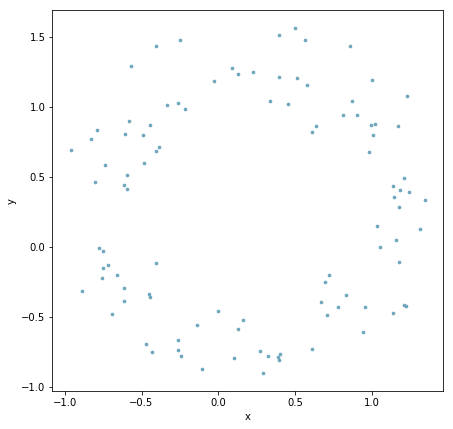

In [14]:
pd.DataFrame(pc).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

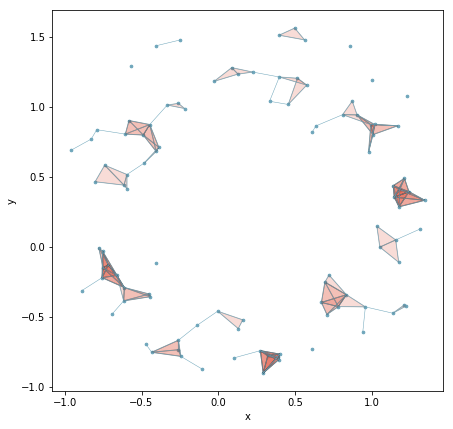

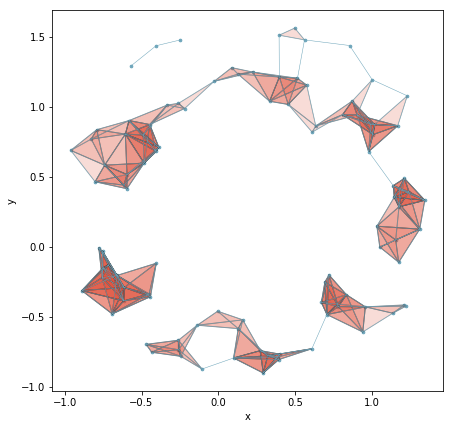

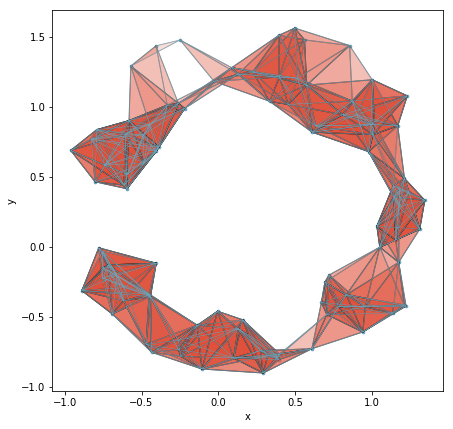

In [15]:
plot_two_simplexes(point_cloud=pc, distance_matrix=dm, epsilon=0.2);
plot_two_simplexes(point_cloud=pc, distance_matrix=dm, epsilon=0.3);
plot_two_simplexes(point_cloud=pc, distance_matrix=dm, epsilon=0.45);

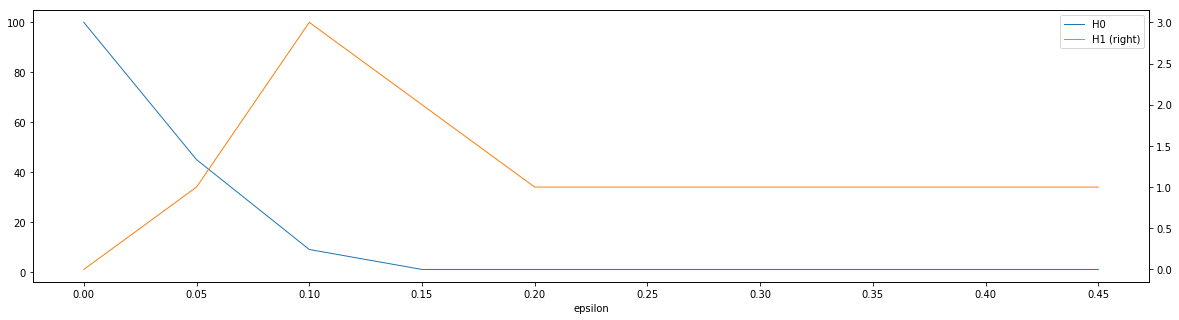

In [16]:
distance_mtx = dm
num_epsilon_steps = [x*0.05 for x in range(1, 10)]
max_simplex_dim = 2
method = None


# build the filtration to be used for persistent homology calculation
filtration, time_epsilon, epsilon_range, simplexes_total = distance_matrix_to_filtration(distance_matrix=distance_mtx,
                                                                           num_epsilon_steps=num_epsilon_steps,
                                                                           max_simplex_dim=max_simplex_dim,
                                                                           method=method)

# calculate persistent homology
persistent_homology = d.homology_persistence(filtration)

# initialize persistence diagrams
diagrams = d.init_diagrams(persistent_homology, filtration)

points = []
for i, diagram in enumerate(diagrams):
        for point in diagram:
            points.append((i, point.birth, point.death))

persistence_data = pd.DataFrame(points, columns=['dimension', 'birth', 'death'])

homology_persistence = {'h{N}_persistence'.format(N=n): [] for n in range(0, max_simplex_dim)}

for n in range(0, max_simplex_dim):
    for i in persistence_data[persistence_data['dimension'] == n].index:
        a = np.array(range(1, len(time_epsilon)+1))
        homology_persistence['h{N}_persistence'.format(N=n)].append(((a >= persistence_data.loc[i]['birth']) & (a <= persistence_data.loc[i]['death'])).astype(int))

time_breaks = sorted([max([key for key, value in time_epsilon.items() if value == epsilon]) - 1 for epsilon in list(set(time_epsilon.values()))])

# initialize the data frame H
H = pd.DataFrame()  
H['epsilon'] = epsilon_range

for n in range(0, max_simplex_dim):
    cycle_sum = np.sum([cycle[time_breaks] for cycle in homology_persistence['h{N}_persistence'.format(N=n)]], axis=0)
    if type(cycle_sum) == np.float64:
        cycle_sum = np.array([cycle_sum])

    H = pd.concat([H, pd.DataFrame(data=cycle_sum, columns=['H{N}'.format(N=n)])], axis=1, ignore_index=False)

H = H.fillna(method='ffill')

H.plot(
    kind='line',
    lw=1,
    x='epsilon',
    figsize=(20, 5),
    secondary_y='H1',
    xticks=H['epsilon'].values
);

## Noisy sine

In [17]:
n_steps = 60
rrand = 20
alpha = 0.6

ts = np.sin([(16*np.pi*x + rrand*random.random())/(n_steps) + alpha*random.random() for x in range(n_steps)])

pcld = time_series_to_point_cloud(time_series=np.array(ts), dimension_embed=2)

dm = distance_matrix(pcld, pcld)

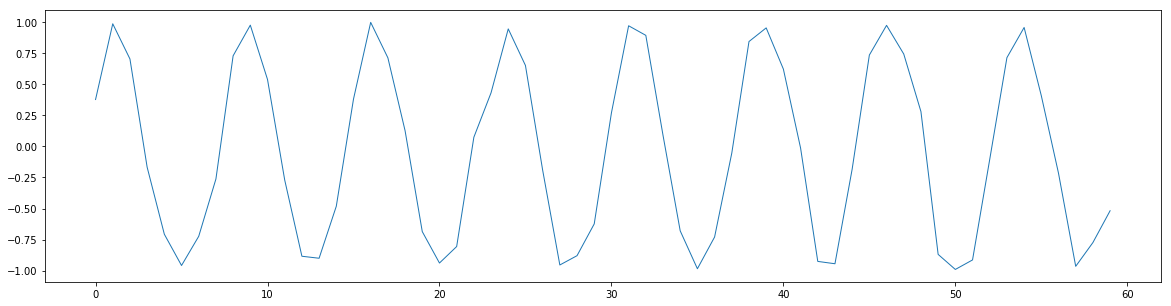

In [18]:
pd.DataFrame(ts).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    legend=False
);

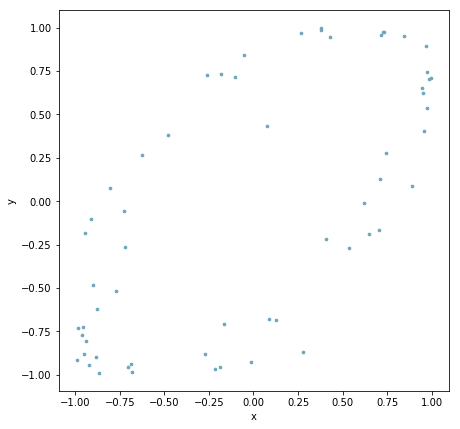

In [19]:
pd.DataFrame(pcld).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

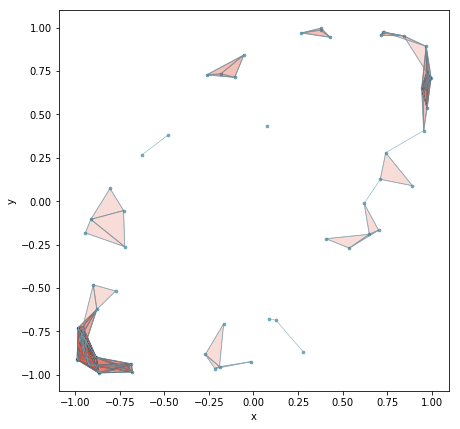

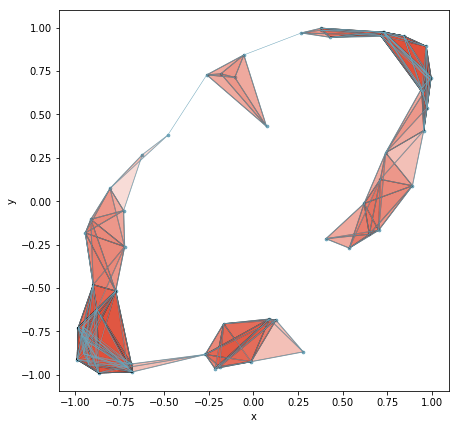

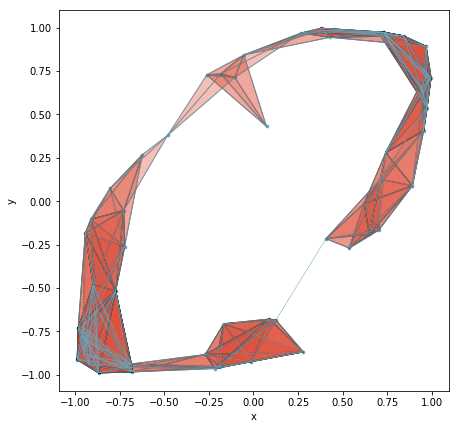

In [20]:
plot_two_simplexes(point_cloud=pcld, distance_matrix=dm, epsilon=0.25);
plot_two_simplexes(point_cloud=pcld, distance_matrix=dm, epsilon=0.45);
plot_two_simplexes(point_cloud=pcld, distance_matrix=dm, epsilon=0.55);

In [21]:
dmx = dm.max()

bmtx = betti_matrix(
    time_series=ts,
    dimension_embed=2,
    num_epsilon_steps=[e/float(dmx) for e in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]],
    max_simplex_dim=2,
    method=None)

In [22]:
bmtx_df = pd.DataFrame(bmtx).rename(columns={
    0: 'beta_0',
    1: 'beta_1'
})

In [23]:
bmtx_df['epsilon'] = [e/float(dmx) for e in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]]

In [24]:
bmtx_df

,beta_0,beta_1,epsilon
0,59,0,0.000000
1,45,1,0.018768
2,33,0,0.037536
3,22,0,0.056304
4,13,0,0.075072
5,9,0,0.093840
6,5,0,0.112608
7,3,0,0.131376
8,3,0,0.150144
9,1,0,0.168912


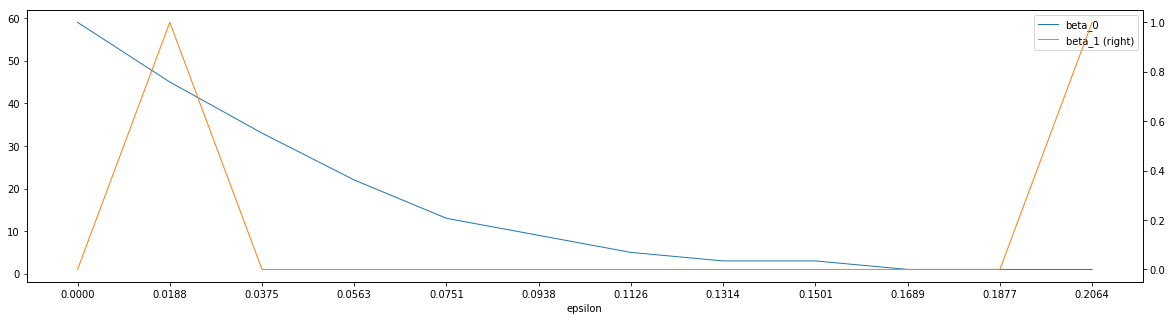

In [25]:
bmtx_df.plot(
    kind='line',
    lw=1,
    x='epsilon',
    secondary_y='beta_1',
    xticks=bmtx_df['epsilon'].values,
    figsize=(20, 5)
);

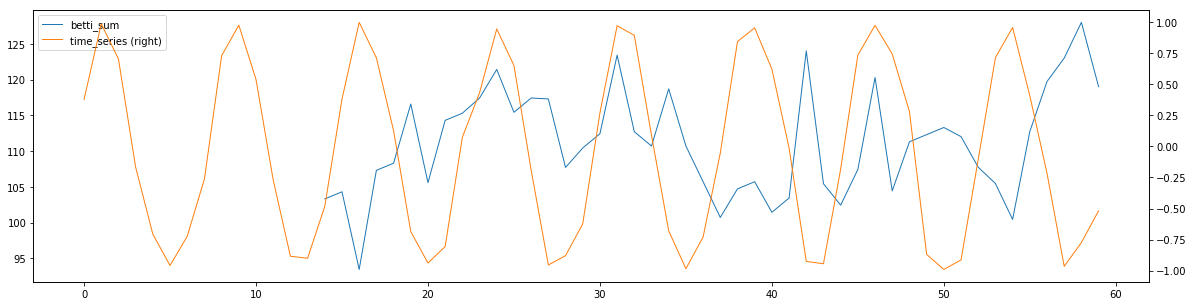

In [26]:
bt_sum = pd.DataFrame(ts).rolling(15).apply(lambda x: betti_sum(time_series=x,
                                                                dimension_embed=2,
                                                                num_epsilon_steps=[e/float(dmx) for e in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]],
                                                                max_simplex_dim=2,
                                                                method=None))

bt_sum.rename(columns={0: 'betti_sum'}, inplace=True)

bt_sum['time_series'] = ts

# plot_two_simplexes(point_cloud=pcld, distance_matrix=dm, epsilon=0.35);

bt_sum.plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='time_series'
);

## Increasing randomness

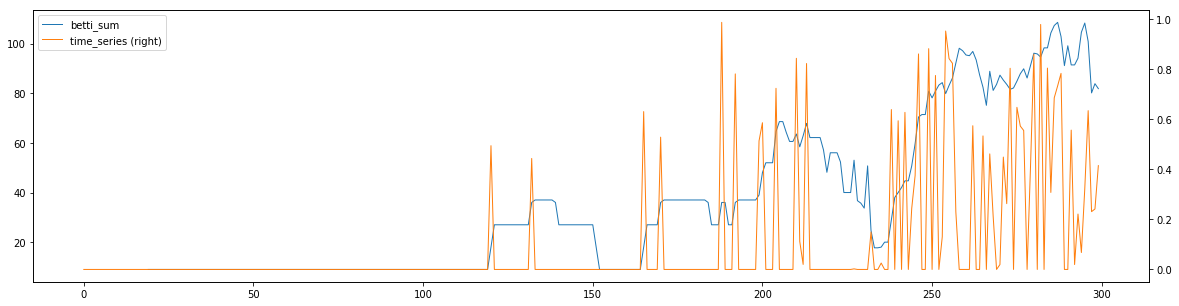

In [27]:
n_steps = 300
power = 4
time_series = [choice(a=[0, random.random()], p=[1-((x/float(n_steps))**power), (x/float(n_steps))**power ]) for x in range(n_steps)]

point_cloud = time_series_to_point_cloud(np.array(time_series), dimension_embed=2)

dmtx = distance_matrix(point_cloud, point_cloud)
dmx = dmtx.max()

bt_sum = pd.DataFrame(time_series).rolling(20).apply(lambda x: betti_sum(time_series=x,
                                                                dimension_embed=2,
                                                                num_epsilon_steps=[e/float(dmx) for e in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]],
                                                                max_simplex_dim=2,
                                                                method=None))

bt_sum.rename(columns={0: 'betti_sum'}, inplace=True)

bt_sum['time_series'] = time_series

bt_sum.plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    secondary_y='time_series'
);